## Import packages

In [1]:
import pandas as pd
import geojson as gsn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import spatial analysis packages
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import geoplot.crs as gcrs
import geoplot as gplt
import pyproj
from shapely.geometry import Polygon
import haversine as hs

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Ground Measures Data

### Load Ground Measure data

Ground measure data provides us with the measure snow water equivalent (SWE) at SNOTEC and CDEC sites across western U.S.

In [2]:
gm_md = pd.read_csv("../data/ground_measures_metadata.csv")
gm_md = gpd.GeoDataFrame(gm_md, geometry=gpd.points_from_xy(gm_md.longitude, gm_md.latitude))
gm_md

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,POINT (-119.14173 37.72663)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
3,CDEC:BCB,Blackcap Basin,3139.440000,37.066685,-118.773010,California,POINT (-118.77301 37.06668)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
...,...,...,...,...,...,...,...
759,SNOTEL:994_WA_SNTL,Epa Quinault Open,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
760,SNOTEL:995_WA_SNTL,Epa Quinault Can,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
761,SNOTEL:996_WA_SNTL,NWA Heather Mdws,1267.968018,48.849998,-121.666672,Washington,POINT (-121.66667 48.85000)
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington,POINT (-121.43895 48.85933)


In [3]:
gm_md.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   station_id   764 non-null    object  
 1   name         764 non-null    object  
 2   elevation_m  764 non-null    float64 
 3   latitude     764 non-null    float64 
 4   longitude    764 non-null    float64 
 5   state        764 non-null    object  
 6   geometry     764 non-null    geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 41.9+ KB


## Cell grids


### Load cell grid data

This [dataset]("../data/grid_cells.geojson") provides us spatial information about the grid cells that we're modelling for.

In [4]:
path = "../data/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))
# gj['features']

18130


In [5]:
gj.keys()

dict_keys(['type', 'crs', 'features'])

In [6]:
gj['features'][1]

{"geometry": {"coordinates": [[[-107.076787, 37.780424], [-107.076787, 37.787523], [-107.08577, 37.787523], [-107.08577, 37.780424], [-107.076787, 37.780424]]], "type": "Polygon"}, "properties": {"cell_id": "000617d8-8c14-43e2-b708-7e3a69fe3cc3", "region": "central rockies"}, "type": "Feature"}

Let's transform our geojson data into a dataframe so its easier to look at and work with

In [7]:
grid_cell_df = pd.DataFrame.from_dict(gj['features'])
grid_cell_df['cell_id'] = [x['cell_id'] for x in grid_cell_df['properties']]
grid_cell_df['coordinates'] = [x['coordinates'][0][0:] for x in grid_cell_df['geometry']]
grid_cell_df['region'] = [x['region'] for x in grid_cell_df['properties']]
grid_cell_df = grid_cell_df.drop(['type','geometry','properties'],axis=1)
grid_cell_df

,cell_id,coordinates,region
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies
2,000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras
...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras
18126,ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,"[[-123.372226, 47.732416], [-123.372226, 47.73...",other


In [8]:
#Make new columns for latitude and longitude of the center of the grid cell

grid_cell_df['centr_lat'] = [list(np.mean(x['coordinates'],axis=0))[0] for index, x in grid_cell_df.iterrows()]
grid_cell_df['centr_lon'] = [list(np.mean(x['coordinates'],axis=0))[1] for index, x in grid_cell_df.iterrows()]
grid_cell_df

,cell_id,coordinates,region,centr_lat,centr_lon
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras,-118.722546,37.077059
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies,-107.080380,37.783264
2,000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other,-119.405266,37.026874
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras,-119.324418,37.434560
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras,-118.524917,36.660236
...,...,...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras,-118.623732,37.120049
18126,ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other,-123.501584,47.903727
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras,-119.647811,37.882592
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,"[[-123.372226, 47.732416], [-123.372226, 47.73...",other,-123.375819,47.734833


In [9]:
#Check data types in this dataframe
grid_cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18130 entries, 0 to 18129
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cell_id      18130 non-null  object 
 1   coordinates  18130 non-null  object 
 2   region       18130 non-null  object 
 3   centr_lat    18130 non-null  float64
 4   centr_lon    18130 non-null  float64
dtypes: float64(2), object(3)
memory usage: 708.3+ KB


### Visualizing location of our cell grids.

Let's visualize the locations of our data so we know where in the map we are working in and if there's any unsual locations hidden in our data.

In [10]:
#transform grid cell data to geopandas df

geometry = [Polygon(eval(str(xy_string))) for xy_string in grid_cell_df['coordinates']]
grid_cell_df = gpd.GeoDataFrame(grid_cell_df,geometry=geometry)

<AxesSubplot:>

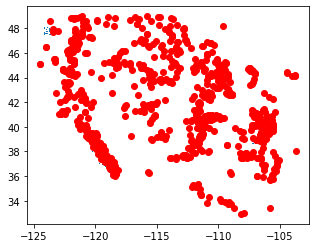

In [11]:
ax = grid_cell_df.plot()
gm_md.plot(ax=ax,c='r')

In [12]:
# drop_stations= gm_md.drop(gm_md[(gm_md['station_id'].isin(filter_list))].index)
# drop_stations

NameError: name 'filter_list' is not defined

In [ ]:
# drop_stations.plot()


## Training data

### Ground measures

Below is the SWE values from ground stations for our training dataset. 

In [13]:
gm_train_feat = pd.read_csv("../data/ground_measures_train_features.csv")
gm_train_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


In [14]:
# stations_train = list(gm_train_feat['station_id'].values)
# len(stations_train)

Let's find out if these stations carry any nulls.

<AxesSubplot:>

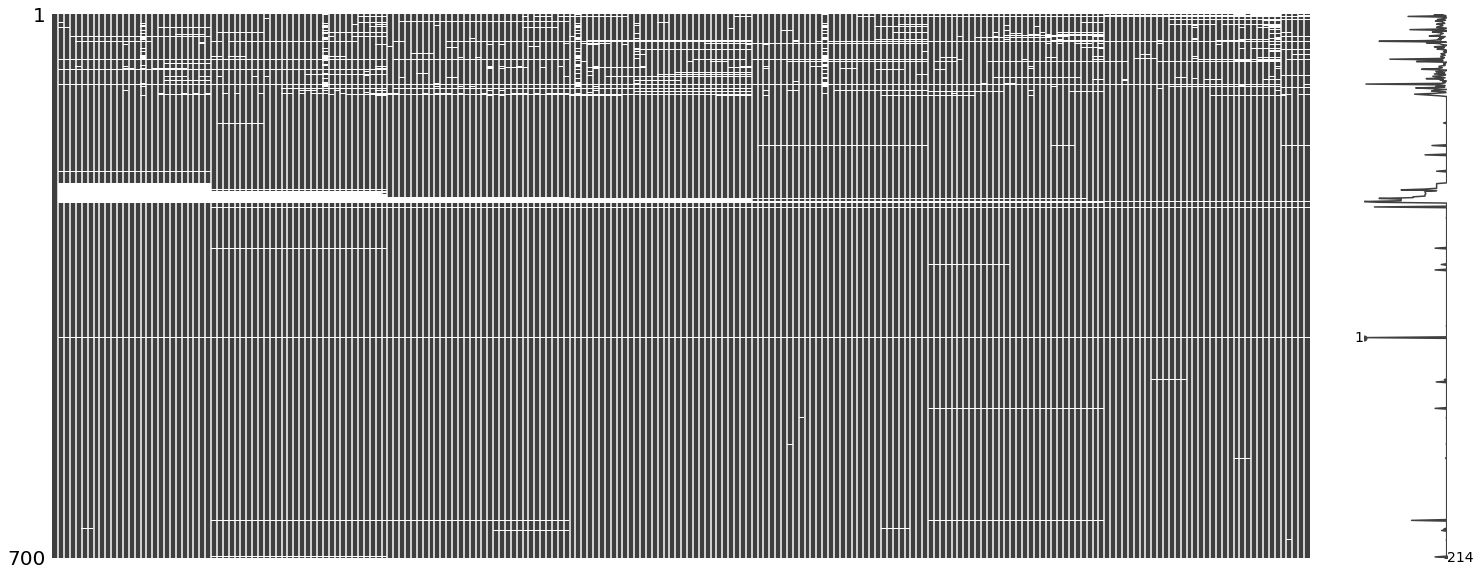

In [15]:
import missingno as msno

msno.matrix(gm_train_feat)

Based on the above heatmap of NaNs, there are a number of stations that have completely null values, and a number of stations that are mostly null values. Let's find out which stations have the most nulls.

In [ ]:
# pd.set_option('display.max_columns', None)


In [16]:
# Transpose and set station id as columns 
gm_t=gm_train_feat.T
gm_t.columns = gm_t.iloc[0]
gm_t = gm_t[1:]
gm_t

station_id,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BGP,CDEC:BIM,CDEC:BKL,CDEC:BLA,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2013-01-01,5.9,17.52,12.75,4.3,2.88,6.6,7.2,19.32,16.56,4.92,...,6.0,1.1,1.0,3.9,19.2,9.0,27.5,4.1,48.4,33.1
2013-01-08,5.9,17.54,13.32,4.42,3.0,7.92,7.28,19.32,17.04,5.64,...,6.6,1.2,1.6,4.3,20.0,10.2,29.1,4.1,55.5,37.5
2013-01-15,6.5,17.85,14.26,4.62,3.48,8.76,7.79,20.16,18.72,7.32,...,7.7,1.8,1.5,5.1,21.7,10.9,31.5,4.4,61.5,40.8
2013-01-22,6.5,17.39,14.02,4.53,3.84,9.0,7.8,20.28,19.2,7.56,...,8.0,1.9,2.0,5.1,21.9,11.1,31.9,4.5,62.2,42.5
2013-01-29,7.4,18.03,13.39,4.67,3.96,10.44,8.35,20.52,19.08,8.28,...,9.7,2.3,2.1,6.4,23.5,12.8,33.4,4.8,67.5,47.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03,0.7,0.0,5.69,NaN,2.88,3.0,NaN,NaN,6.72,0.0,...,1.5,1.4,2.5,1.4,5.9,0.3,1.0,2.0,8.0,1.6
2019-12-10,1.2,0.6,8.04,NaN,4.56,3.36,NaN,NaN,5.88,0.12,...,2.7,1.7,2.7,1.6,7.7,0.2,0.9,2.2,9.0,0.2
2019-12-17,3.4,0.2,10.74,NaN,4.68,4.56,NaN,NaN,6.12,0.72,...,4.4,1.7,2.7,2.6,9.0,1.6,2.3,3.5,13.2,3.5
2019-12-24,3.7,NaN,12.67,NaN,5.04,5.04,NaN,NaN,10.56,0.36,...,5.0,1.6,2.5,2.3,14.5,2.8,8.7,3.6,23.7,8.4


In [17]:
#Look at percentage of null values 
(gm_t.isna().sum().sort_values(ascending=False)[:50])*100/213

station_id
SNOTEL:549_NV_SNTL     100.000000
SNOTEL:1286_MT_SNTL    100.000000
CDEC:SSM                98.122066
SNOTEL:305_CO_SNTL      87.793427
SNOTEL:1287_MT_SNTL     83.568075
CDEC:FRW                82.159624
SNOTEL:1272_NV_SNTL     82.159624
CDEC:LLP                69.014085
SNOTEL:1277_CA_SNTL     55.399061
SNOTEL:1280_UT_SNTL     55.399061
SNOTEL:1252_CO_SNTL     55.399061
SNOTEL:1278_UT_SNTL     55.399061
CDEC:BCB                46.948357
CDEC:CRL                44.600939
SNOTEL:878_WY_SNTL      42.723005
SNOTEL:1269_UT_SNTL     40.845070
SNOTEL:1271_AZ_SNTL     40.845070
CDEC:WHW                38.967136
CDEC:TNY                37.558685
CDEC:MDW                36.619718
CDEC:PSN                30.516432
SNOTEL:1256_WA_SNTL     26.291080
SNOTEL:1263_WA_SNTL     26.291080
SNOTEL:1251_CO_SNTL     26.291080
SNOTEL:1257_WA_SNTL     26.291080
SNOTEL:1261_UT_SNTL     26.291080
SNOTEL:1262_NV_SNTL     26.291080
SNOTEL:1148_UT_SNTL     26.291080
SNOTEL:1258_CA_SNTL     25.821596
SNO

Quite a number of these stations have more than 50% of their data as nulls. Let's drop stations that have more than 60% nulls and impute the other stations will nulls using KNN imputer.

#### Dropping nulls in ground measure stations

In [18]:
# Create mask for stations more than 60% nulls 
mask = ((gm_t.isna().sum().sort_values(ascending=False))*100/213)<60

#Filter and get the list
filter_list = list((gm_t.isna().sum().sort_values(ascending=False))[mask].index)
filter_list

#Drop the stations in the original dataframe
gm_train_feat = gm_train_feat[(gm_train_feat['station_id'].isin(filter_list))]
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


<AxesSubplot:>

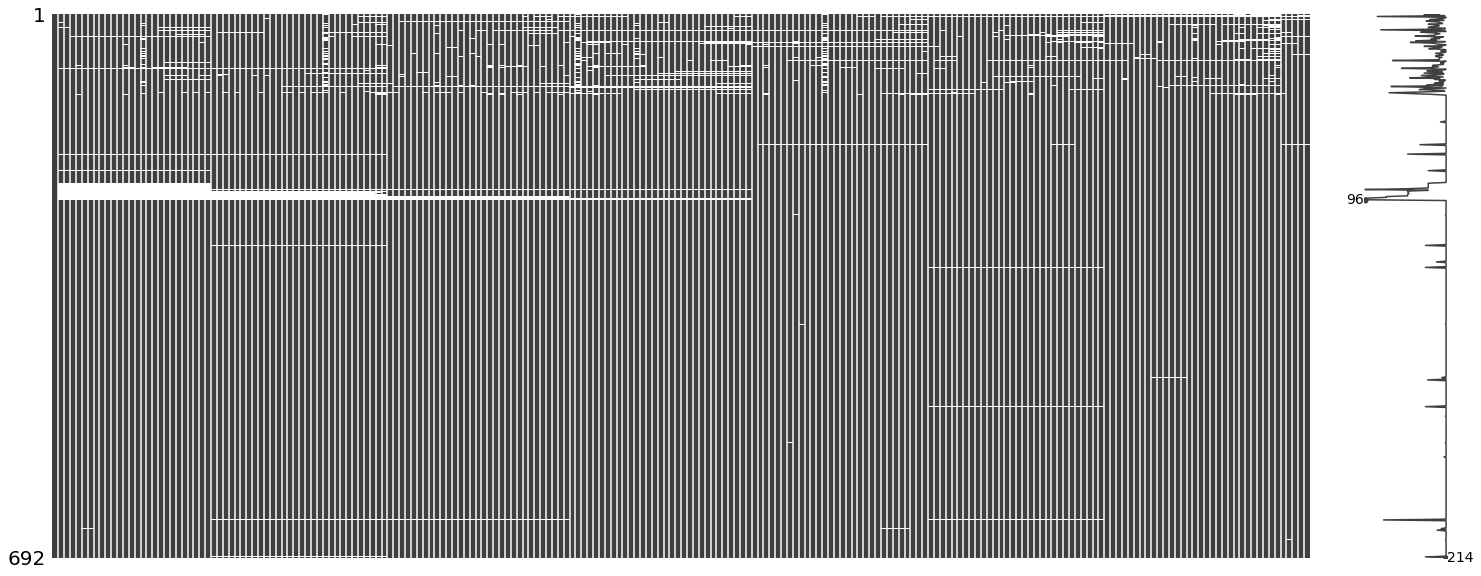

In [19]:
import missingno as msno

msno.matrix(gm_train_feat)

#### Interpolate missing values using Spline interpolation

We'll treat each station as a time series to do interpolation. This will ensure we take into account any seasonality or temporal pattern in our data.

In [20]:
# Transpose and set station id as columns 
gm_t=gm_train_feat.T
gm_t.columns = gm_t.iloc[0]
gm_t = gm_t[1:]
gm_t

station_id,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BGP,CDEC:BIM,CDEC:BKL,CDEC:BLA,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2013-01-01,5.9,17.52,12.75,4.3,2.88,6.6,7.2,19.32,16.56,4.92,...,6.0,1.1,1.0,3.9,19.2,9.0,27.5,4.1,48.4,33.1
2013-01-08,5.9,17.54,13.32,4.42,3.0,7.92,7.28,19.32,17.04,5.64,...,6.6,1.2,1.6,4.3,20.0,10.2,29.1,4.1,55.5,37.5
2013-01-15,6.5,17.85,14.26,4.62,3.48,8.76,7.79,20.16,18.72,7.32,...,7.7,1.8,1.5,5.1,21.7,10.9,31.5,4.4,61.5,40.8
2013-01-22,6.5,17.39,14.02,4.53,3.84,9.0,7.8,20.28,19.2,7.56,...,8.0,1.9,2.0,5.1,21.9,11.1,31.9,4.5,62.2,42.5
2013-01-29,7.4,18.03,13.39,4.67,3.96,10.44,8.35,20.52,19.08,8.28,...,9.7,2.3,2.1,6.4,23.5,12.8,33.4,4.8,67.5,47.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03,0.7,0.0,5.69,NaN,2.88,3.0,NaN,NaN,6.72,0.0,...,1.5,1.4,2.5,1.4,5.9,0.3,1.0,2.0,8.0,1.6
2019-12-10,1.2,0.6,8.04,NaN,4.56,3.36,NaN,NaN,5.88,0.12,...,2.7,1.7,2.7,1.6,7.7,0.2,0.9,2.2,9.0,0.2
2019-12-17,3.4,0.2,10.74,NaN,4.68,4.56,NaN,NaN,6.12,0.72,...,4.4,1.7,2.7,2.6,9.0,1.6,2.3,3.5,13.2,3.5
2019-12-24,3.7,NaN,12.67,NaN,5.04,5.04,NaN,NaN,10.56,0.36,...,5.0,1.6,2.5,2.3,14.5,2.8,8.7,3.6,23.7,8.4


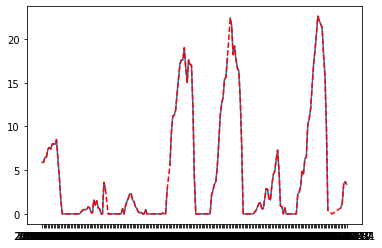

In [21]:
#Set date to datetime and as index
# gm_t.index = pd.to_datetime(gm_t.index)

#Test interpolation code on 1 station
plt.plot(gm_t ['CDEC:ADM'])
interpolated = gm_t['CDEC:ADM'].astype(float).interpolate(option='spline')

plt.plot(interpolated, color='r', linestyle='--')

In [22]:
#Get list of our columns
stations_list = list(gm_t.columns)


#Apply interpolation to every station
for station in stations_list:
    gm_t[station] = gm_t[station].astype(float).interpolate(option='spline')

#Sniff test
gm_t

station_id,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BGP,CDEC:BIM,CDEC:BKL,CDEC:BLA,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2013-01-01,5.9,17.52,12.75,4.30,2.88,6.60,7.20,19.32,16.56,4.92,...,6.0,1.1,1.0,3.9,19.2,9.0,27.5,4.1,48.4,33.1
2013-01-08,5.9,17.54,13.32,4.42,3.00,7.92,7.28,19.32,17.04,5.64,...,6.6,1.2,1.6,4.3,20.0,10.2,29.1,4.1,55.5,37.5
2013-01-15,6.5,17.85,14.26,4.62,3.48,8.76,7.79,20.16,18.72,7.32,...,7.7,1.8,1.5,5.1,21.7,10.9,31.5,4.4,61.5,40.8
2013-01-22,6.5,17.39,14.02,4.53,3.84,9.00,7.80,20.28,19.20,7.56,...,8.0,1.9,2.0,5.1,21.9,11.1,31.9,4.5,62.2,42.5
2013-01-29,7.4,18.03,13.39,4.67,3.96,10.44,8.35,20.52,19.08,8.28,...,9.7,2.3,2.1,6.4,23.5,12.8,33.4,4.8,67.5,47.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03,0.7,0.00,5.69,81.22,2.88,3.00,7.33,21.24,6.72,0.00,...,1.5,1.4,2.5,1.4,5.9,0.3,1.0,2.0,8.0,1.6
2019-12-10,1.2,0.60,8.04,81.22,4.56,3.36,7.33,21.24,5.88,0.12,...,2.7,1.7,2.7,1.6,7.7,0.2,0.9,2.2,9.0,0.2
2019-12-17,3.4,0.20,10.74,81.22,4.68,4.56,7.33,21.24,6.12,0.72,...,4.4,1.7,2.7,2.6,9.0,1.6,2.3,3.5,13.2,3.5
2019-12-24,3.7,0.20,12.67,81.22,5.04,5.04,7.33,21.24,10.56,0.36,...,5.0,1.6,2.5,2.3,14.5,2.8,8.7,3.6,23.7,8.4


In [23]:
#Look at percentage of null values 
(gm_t.isna().sum().sort_values(ascending=False)[:50])*100/213

station_id
SNOTEL:1280_UT_SNTL    55.399061
SNOTEL:1278_UT_SNTL    55.399061
SNOTEL:1277_CA_SNTL    55.399061
SNOTEL:1252_CO_SNTL    55.399061
SNOTEL:1271_AZ_SNTL    40.845070
SNOTEL:1269_UT_SNTL    40.845070
CDEC:PSN               26.291080
SNOTEL:1263_WA_SNTL    26.291080
SNOTEL:1262_NV_SNTL    26.291080
SNOTEL:1261_UT_SNTL    26.291080
SNOTEL:1257_WA_SNTL    26.291080
SNOTEL:1251_CO_SNTL    26.291080
SNOTEL:1256_WA_SNTL    26.291080
SNOTEL:1148_UT_SNTL    26.291080
SNOTEL:1258_CA_SNTL    25.821596
SNOTEL:1259_WA_SNTL    25.352113
SNOTEL:1243_NV_SNTL    12.206573
SNOTEL:1244_NV_SNTL    12.206573
SNOTEL:1247_UT_SNTL    12.206573
SNOTEL:1248_UT_SNTL    12.206573
SNOTEL:1249_UT_SNTL    12.206573
SNOTEL:1254_NM_SNTL    12.206573
SNOTEL:1242_NV_SNTL    12.206573
SNOTEL:1236_UT_SNTL    12.206573
SNOTEL:1187_CO_SNTL    12.206573
CDEC:CDP                0.938967
CDEC:BLC                0.469484
SNOTEL:616_WY_SNTL      0.000000
SNOTEL:615_NV_SNTL      0.000000
SNOTEL:617_AZ_SNTL      0.000000

In [24]:
#Check for patterns in the missing values

dump_list = list((gm_t.isna().sum().sort_values(ascending=False)[:10]).index)

gm_t[dump_list].head(100)

station_id,SNOTEL:1280_UT_SNTL,SNOTEL:1278_UT_SNTL,SNOTEL:1277_CA_SNTL,SNOTEL:1252_CO_SNTL,SNOTEL:1271_AZ_SNTL,SNOTEL:1269_UT_SNTL,CDEC:PSN,SNOTEL:1263_WA_SNTL,SNOTEL:1262_NV_SNTL,SNOTEL:1261_UT_SNTL
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2016-01-26,NaN,NaN,NaN,NaN,10.8,5.7,12.5,21.7,4.7,5.3
2016-02-02,NaN,NaN,NaN,NaN,12.3,6.6,14.1,21.5,5.9,6.2
2016-02-09,NaN,NaN,NaN,NaN,12.2,6.7,14.0,23.8,5.9,6.5
2016-02-16,NaN,NaN,NaN,NaN,12.0,6.7,13.4,23.8,3.8,6.5


So all the remaining stations that have more than 50% of missing values seem to have missing values between 2013 until 2016. While stations with 40% of missing values after interpolation are missing values from 2013 until the end of 2015. 

It's impossible to interpolate 4 straight years of missing data. So, let's rid of the stations that have more than 50% of missing values from those 4 missing years.

In [25]:
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


In [26]:
#Transpose back to our original dataframe shape.
gm_train_feat=gm_t.T
gm_train_feat.reset_index(inplace=True)

#Drop more stations
dump_list = list((gm_t.isna().sum().sort_values(ascending=False)[:4]).index)

#Add on stations that doesn't have data the whole of 2019.
dump_list.extend(['CDEC:BCB','CDEC:BGP','CDEC:BIM'])

#Filter and get the list
mask = ~(gm_train_feat['station_id'].isin(dump_list))

#Drop the stations in the original dataframe
gm_train_feat = gm_train_feat[mask]
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,0.116667,0.233333,0.350000,0.466667,0.583333,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,0.251613,0.201290,0.150968,0.100645,0.050323,0.00,0.60,0.20,0.20,0.20
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.520000,20.810000,8.710000,0.300000,0.000000,5.69,8.04,10.74,12.67,12.57
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.840000,0.600000,0.360000,0.360000,0.240000,2.88,4.56,4.68,5.04,6.00
5,CDEC:BFL,6.60,7.92,8.76,9.00,10.44,10.80,11.16,11.28,12.00,...,0.270000,0.150000,0.270000,0.390000,0.270000,3.00,3.36,4.56,5.04,5.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.30,0.20,1.60,2.80,3.00
688,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.000000,0.100000,0.000000,0.000000,0.000000,1.00,0.90,2.30,8.70,8.60
689,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.00,2.20,3.50,3.60,3.80
690,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.600000,36.100000,31.300000,8.500000,0.000000,8.00,9.00,13.20,23.70,25.00


Let's update our ground measures station list with the updated stations

In [27]:
stations_list = list(gm_train_feat.station_id.unique())
gm_md = gm_md[gm_md['station_id'].isin(stations_list)]
gm_md

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,POINT (-119.14173 37.72663)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
5,CDEC:BFL,Big Flat,1554.480000,41.077599,-122.942230,California,POINT (-122.94223 41.07760)
...,...,...,...,...,...,...,...
755,SNOTEL:989_ID_SNTL,Moscow Mountain,1432.560059,46.805000,-116.853500,Idaho,POINT (-116.85350 46.80500)
756,SNOTEL:990_WA_SNTL,Beaver Pass,1106.423950,48.879299,-121.255501,Washington,POINT (-121.25550 48.87930)
758,SNOTEL:992_UT_SNTL,Bear River RS,2675.229492,40.885201,-110.827698,Utah,POINT (-110.82770 40.88520)
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington,POINT (-121.43895 48.85933)


### Training labels

Below is our ground truth data for each cell grid for each date.

In [28]:
train_labels = pd.read_csv("../data/train_labels.csv")
train_labels = train_labels.melt(id_vars=["cell_id"]).dropna()
train_labels.rename({'variable':'dates'},axis=1,inplace=True)
train_labels

,cell_id,dates,value
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0
120,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3
121,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0
...,...,...,...
2904295,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3
2904321,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6
2904323,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8
2904336,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9


#### Mapping ground measure to training set cell grids

We want to use the SWE of 20 of the nearest ground stations as model features for our cell grids. We will have to which ground stations are nearest to our cell grid first. For this, we will be using [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) package from scipy.

In [ ]:
## This code block gives the wrong distance

# from scipy.spatial.distance import cdist

# mat = dt(gm_md[['latitude','longitude']],grid_cell_df[['centr_lat','centr_lon']],metric='euclidean')
# mat
# nn_train_df = pd.DataFrame(mat, index=gm_md['station_id'], columns=grid_cell_df['cell_id']) 
# nn_df

In [29]:
# Function that Calculates haversine distance
def distance_from(loc1,loc2): 
    dist=hs.haversine(loc1,loc2)
    return round(dist,2)

In [ ]:
# #Test code block for one station

# station='SNOTEL:988_ID_SNTL'
# station_mask = gm_md['station_id']==station
# station_coord = tuple(gm_md[station_mask][['latitude','longitude']].iloc[0])
# nn_df[station] = [distance_from(station_coord, coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]

In [30]:
nn_df = pd.DataFrame()
for station in stations_list:
    station_mask = gm_md['station_id']==station
    station_coord = tuple(gm_md[station_mask][['latitude','longitude']].iloc[0])
    nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
nn_df

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  nn_df[station] = [distance_from(station_coord,coord) for coord in zip(grid_cell_df['centr_lat'],grid_cell_df['centr_lon'])]
C:\Users\hanis\AppData\Local\Temp\ipykernel_9044\1461231269.py

,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCH,CDEC:BFL,CDEC:BKL,CDEC:BLA,CDEC:BLC,CDEC:BLD,CDEC:BLK,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
0,11573.41,11217.53,11316.95,11058.25,11523.96,11414.99,11516.03,11360.93,11281.40,11300.78,...,11927.83,12220.48,12260.16,12164.75,12471.70,12243.88,12401.12,11724.32,12396.39,12382.30
1,12800.63,12430.35,12537.87,12263.24,12762.74,12643.25,12745.03,12585.38,12500.78,12519.73,...,13130.05,13378.93,13374.92,13379.83,13686.62,13455.88,13639.72,12882.68,13635.85,13622.87
2,11501.59,11146.61,11245.54,10987.82,11451.47,11343.14,11444.12,11289.31,11210.09,11229.49,...,11857.39,12152.44,12194.55,12093.53,12400.44,12172.82,12328.54,11656.43,12323.76,12309.60
3,11503.77,11147.96,11247.33,10988.75,11454.32,11345.35,11446.39,11291.30,11211.79,11231.18,...,11858.33,12151.53,12192.03,12095.14,12402.10,12174.29,12331.49,11655.41,12326.76,12312.67
4,11600.95,11245.56,11344.73,11086.53,11551.08,11442.51,11543.52,11388.59,11309.23,11328.63,...,11956.10,12249.70,12290.06,12192.63,12499.56,12271.85,12428.18,11753.58,12423.41,12409.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18125,11583.25,11227.18,11326.70,11067.80,11533.94,11424.84,11525.89,11370.73,11291.14,11310.51,...,11937.38,12229.54,12268.75,12174.46,12481.42,12253.55,12411.13,11733.35,12406.41,12392.33
18126,10919.50,10548.38,10656.16,10381.53,10884.04,10762.33,10864.18,10703.98,10618.99,10637.90,...,11248.78,11508.30,11523.02,11497.86,11804.67,11573.99,11760.33,11011.53,11756.69,11744.04
18127,11462.33,11106.09,11205.68,10946.68,11413.26,11303.93,11405.00,11249.76,11170.10,11189.47,...,11816.26,12108.73,12148.80,12053.40,12360.37,12132.48,12290.50,11612.58,12285.80,12271.75
18128,10934.88,10563.99,10671.64,10397.25,10899.19,10777.68,10879.52,10719.40,10634.49,10653.41,...,11264.58,11524.62,11539.70,11513.48,11820.30,11589.66,11775.54,11027.85,11771.87,11759.20


In [31]:
#Get cell grids list
cells_list = list(grid_cell_df['cell_id'].values)

#Transpose and change column names to cell ids
nn_df = nn_df.T
nn_df.columns = cells_list
nn_df

,0003f387-71c4-48f6-b2b0-d853bd4f0aba,000617d8-8c14-43e2-b708-7e3a69fe3cc3,000863e7-21e6-477d-b799-f5675c348627,000ba8d9-d6d5-48da-84a2-1fa54951fae1,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,0017d1c4-64cb-426d-9158-3f6521d2dd22,0020c632-3d5c-4509-b4ee-6b63a89bf2ff,00211c19-7ea8-4f21-a2de-1d6216186a96,0021411f-e7b5-48d7-9d36-abecbc255821,00226e82-e747-4f03-9c5d-3eef8ebe515e,...,ffca2dc2-ed02-4006-82a3-fa093863fa68,ffcc02b0-5185-4f6a-bdfd-1ae1b6c68e99,ffce8731-d78f-4c06-ace2-7029b611f1ba,ffd1aa25-27a5-4b28-abb6-e6577d1575be,ffdc53d2-5565-496a-b849-4fcf33f33a36,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,ffe43514-2c92-43b6-bd84-d183806aca65,ffeabc13-7c6f-4b63-b043-19c8f15e0345,fff95195-ccc9-40b7-b302-a0d8570c86bc,fffb4d40-5947-4922-9f05-5d8b5a243d84
CDEC:ADM,11573.41,12800.63,11501.59,11503.77,11600.95,11495.32,11557.81,12805.67,10939.48,11417.31,...,12903.92,12739.25,11474.89,12796.97,11533.73,11583.25,10919.50,11462.33,10934.88,10890.47
CDEC:AGP,11217.53,12430.35,11146.61,11147.96,11245.56,11139.98,11202.53,12434.29,10568.10,11061.30,...,12530.86,12369.89,11119.74,12425.55,11178.35,11227.18,10548.38,11106.09,10563.99,10520.19
CDEC:ALP,11316.95,12537.87,11245.54,11247.33,11344.73,11239.10,11301.63,12542.44,10676.04,11160.77,...,12639.98,12476.88,11218.76,12533.72,11277.50,11326.70,10656.16,11205.68,10671.64,10627.49
CDEC:BCH,11058.25,12263.24,10987.82,10988.75,11086.53,10981.01,11043.57,12266.63,10401.12,10902.04,...,12362.31,12203.29,10960.88,12257.88,11019.34,11067.80,10381.53,10946.68,10397.25,10353.79
CDEC:BFL,11523.96,12762.74,11451.47,11454.32,11551.08,11445.49,11507.88,12768.83,10904.24,11368.09,...,12868.61,12700.54,11424.94,12760.17,11483.91,11533.94,10884.04,11413.26,10899.19,10854.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNOTEL:989_ID_SNTL,12243.88,13455.88,12172.82,12174.29,12271.85,12166.24,12228.79,13459.51,11593.65,12087.66,...,13555.48,13395.68,12145.98,13450.76,12204.63,12253.55,11573.99,12132.48,11589.66,11546.01
SNOTEL:990_WA_SNTL,12401.12,13639.72,12328.54,12331.49,12428.18,12322.61,12384.97,13645.60,11780.47,12245.30,...,13745.02,13577.65,12302.03,13636.92,12361.03,12411.13,11760.33,12290.50,11775.54,11730.71
SNOTEL:992_UT_SNTL,11724.32,12882.68,11656.43,11655.41,11753.58,11648.83,11711.15,12882.73,11030.26,11568.77,...,12972.49,12825.93,11629.25,12873.95,11686.82,11733.35,11011.53,11612.58,11027.85,10986.46
SNOTEL:998_WA_SNTL,12396.39,13635.85,12323.76,12326.76,12423.41,12317.85,12380.21,13641.81,11776.85,12240.60,...,13741.36,13573.72,12297.27,13633.14,12356.27,12406.41,11756.69,12285.80,11771.87,11727.01


Get 20 nearest neighbor and put it in our cell grid dataframe.

In [32]:
#Sniff test

nn_df['000863e7-21e6-477d-b799-f5675c348627'].sort_values(ascending=True)[:20]

SNOTEL:755_NM_SNTL     10871.55
SNOTEL:1048_NM_SNTL    10887.82
SNOTEL:877_AZ_SNTL     10896.26
SNOTEL:757_NM_SNTL     10904.58
SNOTEL:902_AZ_SNTL     10925.68
SNOTEL:486_NM_SNTL     10937.44
SNOTEL:416_AZ_SNTL     10939.33
SNOTEL:1271_AZ_SNTL    10941.75
SNOTEL:617_AZ_SNTL     10944.10
SNOTEL:1127_AZ_SNTL    10949.27
SNOTEL:308_AZ_SNTL     10953.64
SNOTEL:519_AZ_SNTL     10953.82
SNOTEL:1140_AZ_SNTL    10954.08
CDEC:PSC               10969.46
CDEC:QUA               10982.31
SNOTEL:1034_NM_SNTL    10986.70
CDEC:BCH               10987.82
CDEC:CSV               10996.13
SNOTEL:640_AZ_SNTL     11003.00
CDEC:WTM               11006.81
Name: 000863e7-21e6-477d-b799-f5675c348627, dtype: float64

In [33]:
#Helper function

def nn_20(cell_id,df):
    """
    Get 20 nearest neighbor from dataframe and return a list of the stations names.
    """
    station_list = list(df[cell_id].sort_values(ascending=True)[:20].index)
    return station_list
    

In [34]:
#Put the list of nearest neighbors in our cell grid dataframe.

grid_cell_df['nearest_neighb'] = [nn_20(x,nn_df) for x in grid_cell_df['cell_id']]
grid_cell_df.set_index('cell_id')

,coordinates,region,centr_lat,centr_lon,geometry,nearest_neighb
cell_id,,,,,,
0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras,-118.722546,37.077059,"POLYGON ((-118.71895 37.07419, -118.71895 37.0...","[SNOTEL:755_NM_SNTL, SNOTEL:1048_NM_SNTL, SNOT..."
000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies,-107.080380,37.783264,"POLYGON ((-107.07679 37.78042, -107.07679 37.7...","[SNOTEL:755_NM_SNTL, SNOTEL:1048_NM_SNTL, SNOT..."
000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other,-119.405266,37.026874,"POLYGON ((-119.40167 37.02401, -119.40167 37.0...","[SNOTEL:755_NM_SNTL, SNOTEL:1048_NM_SNTL, SNOT..."
000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras,-119.324418,37.434560,"POLYGON ((-119.32082 37.43171, -119.32082 37.4...","[SNOTEL:755_NM_SNTL, SNOTEL:1048_NM_SNTL, SNOT..."
00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras,-118.524917,36.660236,"POLYGON ((-118.52132 36.65735, -118.52132 36.6...","[SNOTEL:755_NM_SNTL, SNOTEL:1048_NM_SNTL, SNOT..."
...,...,...,...,...,...,...
ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras,-118.623732,37.120049,"POLYGON ((-118.62014 37.11718, -118.62014 37.1...","[SNOTEL:755_NM_SNTL, SNOTEL:1048_NM_SNTL, SNOT..."
ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other,-123.501584,47.903727,"POLYGON ((-123.49799 47.90132, -123.49799 47.9...","[SNOTEL:755_NM_SNTL, SNOTEL:1048_NM_SNTL, SNOT..."
ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras,-119.647811,37.882592,"POLYGON ((-119.64422 37.87976, -119.64422 37.8...","[SNOTEL:755_NM_SNTL, SNOTEL:1048_NM_SNTL, SNOT..."


In [35]:
#Sniff test
grid_cell_df['nearest_neighb'].explode().unique()

array(['SNOTEL:755_NM_SNTL', 'SNOTEL:1048_NM_SNTL', 'SNOTEL:877_AZ_SNTL',
       'SNOTEL:757_NM_SNTL', 'SNOTEL:902_AZ_SNTL', 'SNOTEL:486_NM_SNTL',
       'SNOTEL:416_AZ_SNTL', 'SNOTEL:1271_AZ_SNTL', 'SNOTEL:617_AZ_SNTL',
       'SNOTEL:1127_AZ_SNTL', 'SNOTEL:519_AZ_SNTL', 'SNOTEL:308_AZ_SNTL',
       'SNOTEL:1140_AZ_SNTL', 'CDEC:PSC', 'SNOTEL:1034_NM_SNTL',
       'CDEC:QUA', 'CDEC:BCH', 'CDEC:CSV', 'SNOTEL:640_AZ_SNTL',
       'SNOTEL:488_AZ_SNTL', 'SNOTEL:861_AZ_SNTL', 'SNOTEL:1139_AZ_SNTL',
       'SNOTEL:1121_AZ_SNTL', 'CDEC:WTM', 'SNOTEL:927_AZ_SNTL'],
      dtype=object)

#### Add nearest neighboring stations to training set dataframe

Add neighbors values to our dataframe.

In [54]:
#Function to help us pull nearest neighbor list

def get_neighb_list(df_idx,label_df, grid_df):
    """
    Get the neareset neighbor list for the row
    """
    cell_id = label_df['cell_id'].iloc[df_idx]
    nn_list = grid_df[grid_df['cell_id'] == cell_id]['nearest_neighb'].values[0]

    return nn_list

def get_gm_value(df_idx, station_idx, gm_df,label_df,nn_list):
    value = gm_df[gm_df['station_id'] == nn_list[station_idx]][label_df['dates'].iloc[df_idx]].values[0]
    return value

In [63]:
#Test function
nn_list = get_neighb_list(0,train_labels,grid_cell_df)
get_gm_value(0,0,gm_train_feat,train_labels,nn_list)

2.0

In [66]:
for k in range (0,20):
    print (f"Working on neighbor {k+1}")
    neighbor=[]
    for i in range(0,len(train_labels)):
        nn_list = get_neighb_list(i,train_labels,grid_cell_df)
        try:
            value = get_gm_value(i,k,gm_train_feat,train_labels,nn_list)
        except:
            value = np.NaN
        neighbor.append(value)
#         print (neighbor)
    col_name = f'neighbor_{k+1}'
    train_labels[col_name] = neighbor

Working on neighbor 1
Working on neighbor 2
Working on neighbor 3
Working on neighbor 4
Working on neighbor 5
Working on neighbor 6
Working on neighbor 7
Working on neighbor 8
Working on neighbor 9
Working on neighbor 10
Working on neighbor 11
Working on neighbor 12
Working on neighbor 13
Working on neighbor 14
Working on neighbor 15
Working on neighbor 16
Working on neighbor 17
Working on neighbor 18
Working on neighbor 19
Working on neighbor 20


In [67]:
train_labels

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,6.6,10.60,8.4,2.88,4.10,7.24,4.00
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,10.6,6.60,8.4,2.88,4.10,7.24,4.00
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,10.6,6.60,8.4,2.88,7.24,4.10,4.00
120,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,2.0,1.6,3.2,6.4,2.7,2.0,2.8,...,NaN,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,7.20
121,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,2.0,1.6,3.2,6.4,2.7,2.0,2.8,...,1.6,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,10.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904295,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93
2904321,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93
2904323,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,4.1,3.9,5.5,9.9,5.30,6.9,3.70,9.93,3.90,1.50
2904336,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,1.3,2.7,4.0,6.7,2.1,1.5,2.8,...,3.9,5.5,9.9,4.1,9.93,5.3,10.92,6.90,3.70,6.00


Let's check for null is our new dataframe.

In [69]:
train_labels.isna().sum()

cell_id            0
dates              0
value              0
neighbor_1     41032
neighbor_2     41032
neighbor_3     41032
neighbor_4     41032
neighbor_5     41032
neighbor_6     41032
neighbor_7     41032
neighbor_8     49066
neighbor_9     47731
neighbor_10    44338
neighbor_11    41641
neighbor_12    41032
neighbor_13    41032
neighbor_14    41032
neighbor_15    41032
neighbor_16    41032
neighbor_17    41032
neighbor_18    41032
neighbor_19    41032
neighbor_20    41032
dtype: int64

That's a lot of nulls of the same amount across the neighbors. Most of these nulls probably come from our own code where we set values to null if date exist in grid cell dataframe and not in ground stations dataframe ! Some of the neighbors have more nulls than others too. Let's analyze these and decide what we should do next.

In [71]:
train_labels[train_labels['neighbor_1'].isna()]

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
152344,00ef834b-a1de-4305-b7ef-0800961c7fa2,2013-04-03,28.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152357,01438219-bc42-47bb-8a4f-d50d4c8bcfed,2013-04-03,31.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152424,02fa9f4d-a454-4e73-8aea-4d19c4ee3e37,2013-04-03,28.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152446,03968d16-5231-4140-b602-61356a1bd393,2013-04-03,15.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152474,04149267-2eeb-4910-8360-f76b2df2ad8d,2013-04-03,23.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838988,fc374249-6186-4986-9c9e-3a3ed64c5aa2,2019-06-24,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2839006,fcb3f308-86b0-48d5-b053-43844d3ec5b4,2019-06-24,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2839105,ff0b561c-3a91-44e7-8054-52f90bcabc59,2019-06-24,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2839109,ff1540b9-01f2-410b-90aa-678f3c4d8ea2,2019-06-24,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
train_labels[train_labels['neighbor_1'].isna()]['dates'].unique() == train_labels[train_labels['neighbor_2'].isna()]['dates'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Since 50% have these dates that contain null, we'll be dropping them. That's a lot of data to drop but we'll still have 50000 observations to train our model on. It will be ok..

In [86]:
#Get dates with missing values for all neighbors
null_dates = list(train_labels[train_labels['neighbor_1'].isna()]['dates'].unique())
null_dates

['2013-04-03',
 '2013-04-29',
 '2013-05-03',
 '2013-05-25',
 '2013-06-01',
 '2013-06-08',
 '2016-02-08',
 '2016-03-26',
 '2016-04-01',
 '2016-04-03',
 '2016-04-04',
 '2016-04-07',
 '2016-04-16',
 '2016-05-09',
 '2016-05-27',
 '2016-06-26',
 '2017-01-28',
 '2017-01-29',
 '2018-03-04',
 '2018-03-30',
 '2018-03-31',
 '2018-04-22',
 '2018-04-23',
 '2018-04-25',
 '2018-04-26',
 '2018-05-24',
 '2018-05-28',
 '2018-06-01',
 '2018-06-02',
 '2019-03-09',
 '2019-03-15',
 '2019-03-16',
 '2019-03-17',
 '2019-03-24',
 '2019-03-25',
 '2019-03-29',
 '2019-04-07',
 '2019-04-08',
 '2019-04-17',
 '2019-04-18',
 '2019-04-19',
 '2019-04-21',
 '2019-04-27',
 '2019-04-28',
 '2019-05-01',
 '2019-05-02',
 '2019-05-03',
 '2019-06-05',
 '2019-06-08',
 '2019-06-09',
 '2019-06-10',
 '2019-06-13',
 '2019-06-14',
 '2019-06-24']

In [92]:
#Create mask to filter rows with dates.
mask = train_labels['dates'].isin(null_dates)

#filter out the rows with the dates
train_labels_cleaned = train_labels[~mask]

#Sniff test
train_labels_cleaned.isna().sum()*100/len(train_labels_cleaned)

cell_id         0.000000
dates           0.000000
value           0.000000
neighbor_1      0.000000
neighbor_2      0.000000
neighbor_3      0.000000
neighbor_4      0.000000
neighbor_5      0.000000
neighbor_6      0.000000
neighbor_7      0.000000
neighbor_8     15.922153
neighbor_9     13.276388
neighbor_10     6.551984
neighbor_11     1.206944
neighbor_12     0.000000
neighbor_13     0.000000
neighbor_14     0.000000
neighbor_15     0.000000
neighbor_16     0.000000
neighbor_17     0.000000
neighbor_18     0.000000
neighbor_19     0.000000
neighbor_20     0.000000
dtype: float64

In [91]:
train_labels_cleaned

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,6.6,10.60,8.4,2.88,4.10,7.24,4.00
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,10.6,6.60,8.4,2.88,4.10,7.24,4.00
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,10.6,6.60,8.4,2.88,7.24,4.10,4.00
120,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,2.0,1.6,3.2,6.4,2.7,2.0,2.8,...,NaN,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,7.20
121,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,2.0,1.6,3.2,6.4,2.7,2.0,2.8,...,1.6,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,10.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904295,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93
2904321,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93
2904323,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,4.1,3.9,5.5,9.9,5.30,6.9,3.70,9.93,3.90,1.50
2904336,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,1.3,2.7,4.0,6.7,2.1,1.5,2.8,...,3.9,5.5,9.9,4.1,9.93,5.3,10.92,6.90,3.70,6.00


Now that we've dropped dates that are complete nulls, we still see that eighboring ground stations 8, 9, 10 still have nulls at specific dates. This is not a ton (between 1 - 15% of our dataset. We can impute this in our modeling workflow.

In [99]:
train_labels_cleaned[train_labels_cleaned['neighbor_8'].isna()]

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,6.60,10.60,8.4,2.88,4.10,7.24,4.00
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,10.60,6.60,8.4,2.88,4.10,7.24,4.00
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,10.60,6.60,8.4,2.88,7.24,4.10,4.00
294,06442780-9a68-424b-9fbe-0184e7d14d2e,2013-01-01,3.6,2.0,1.6,3.2,6.4,2.7,2.0,2.8,...,3.9,4.3,5.9,6.60,10.60,4.1,8.40,4.00,3.40,2.88
325,06ec1554-a0ea-41cf-85f8-43f4b48c7599,2013-01-01,13.4,2.0,1.6,3.2,6.4,2.7,2.0,2.8,...,3.9,6.6,4.3,5.90,4.10,4.0,10.60,3.40,8.40,2.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011032,f1f17cee-3fca-44bc-8974-b72d5f995a4a,2015-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.36,0.0,0.60,0.00,0.00,0.00
1011216,f6106ef5-e6fd-423b-9034-59bce18319da,2015-06-30,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.36,0.00,0.6,0.00,0.44,0.00,0.00
1011242,f6a782f0-4b17-4989-815c-2398b77b09dd,2015-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.36,0.0,0.00,0.00,0.60,0.00
1011407,fa92fd14-b8db-48b2-be54-f57db0a05bda,2015-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.36,0.0,0.00,0.00,0.60,0.00


In [98]:
#Dates of missing values in neighbor 8 
train_labels_cleaned[train_labels_cleaned['neighbor_8'].isna()]['dates'].unique()

#Another method of checking for the same thing.
# np.setdiff1d(list(train_labels[train_labels['neighbor_8'].isna()]['dates'].unique()), null_dates) 


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [240]:
train_labels_cleaned

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,...,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,6.6,10.60,8.4,2.88,4.10,7.24,4.00
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,10.6,6.60,8.4,2.88,4.10,7.24,4.00
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,2.0,1.6,6.4,3.2,2.7,2.0,2.8,...,3.9,4.3,5.9,10.6,6.60,8.4,2.88,7.24,4.10,4.00
120,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,2.0,1.6,3.2,6.4,2.7,2.0,2.8,...,NaN,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,7.20
121,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,2.0,1.6,3.2,6.4,2.7,2.0,2.8,...,1.6,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,10.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904295,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93
2904321,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93
2904323,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,1.3,2.7,6.7,4.0,2.1,1.5,2.8,...,4.1,3.9,5.5,9.9,5.30,6.9,3.70,9.93,3.90,1.50
2904336,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,1.3,2.7,4.0,6.7,2.1,1.5,2.8,...,3.9,5.5,9.9,4.1,9.93,5.3,10.92,6.90,3.70,6.00


In [241]:
#Saving dataframe to file for now, just in case.
train_labels_cleaned.to_csv('../data/train_labels_final.csv')

## Testing Data

### Ground measures

Below is the SWE values from ground stations for our testing dataset.

In [220]:
gm_test_feat = pd.read_csv("../data/ground_measures_test_features.csv")
gm_test_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_test_feat

,station_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,4.50,5.50,7.30,8.30,8.10,8.20,9.30,8.50,7.90,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,6.80,12.50,13.10,14.40,16.30,19.10,19.80,19.80,19.70,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,13.80,17.00,20.30,24.90,26.70,29.40,29.80,31.10,32.60,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.40,5.00,5.80,6.20,6.30,6.80,7.20,7.40,7.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,37.90,47.00,51.80,61.90,69.00,73.40,77.30,81.40,83.60,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


We're starting off with 700 ground measure stations and 58 dates, starting in January 2020 to June 2021, for our test set. Let's look at nulls in our ground measure stations.

<AxesSubplot:>

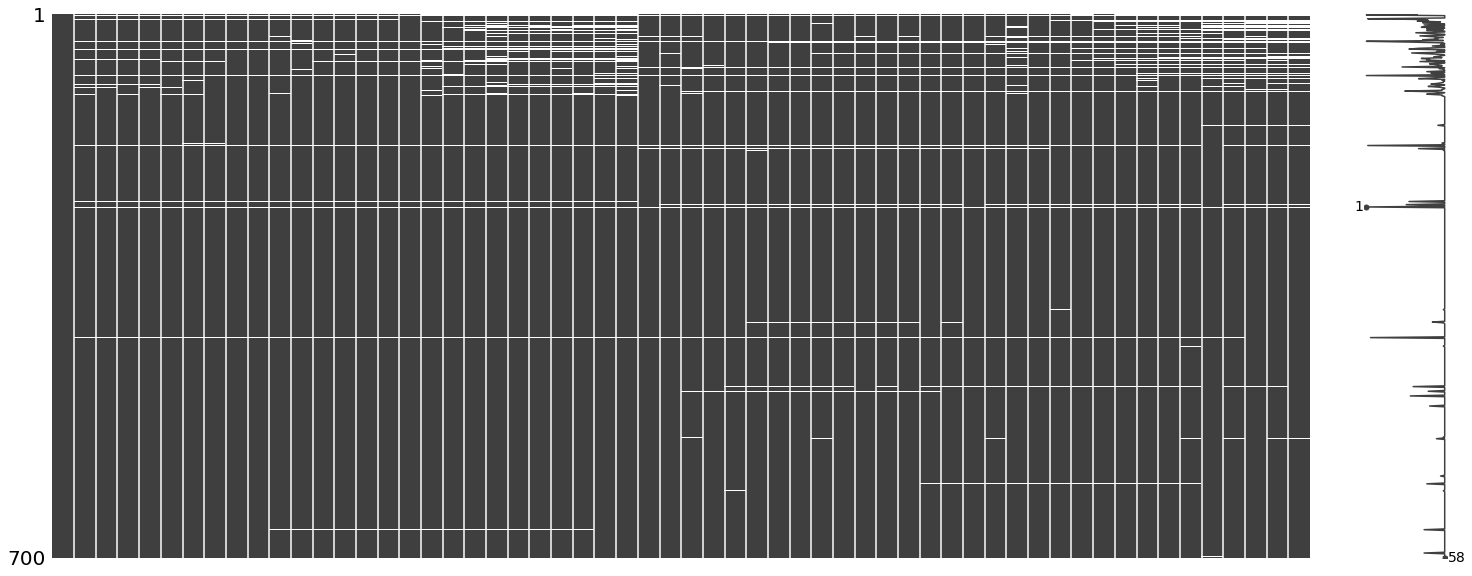

In [204]:
import missingno as msno

msno.matrix(gm_test_feat)

The nulls in our ground measures testing set isn't as bad as our training set. 

#### Dropping nulls in ground measure testing data

In [221]:
# Transpose and set station id as columns 
gm_test_t=gm_test_feat.T
gm_test_t.columns = gm_test_t.iloc[0]
gm_test_t = gm_test_t[1:]
gm_test_t

station_id,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BGP,CDEC:BIM,CDEC:BKL,CDEC:BLA,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2020-01-07,4.5,NaN,12.72,12.2,6.6,5.76,NaN,NaN,12.36,0.48,...,6.9,1.6,2.9,3.7,18.0,6.8,13.8,4.4,37.9,17.7
2020-01-14,5.5,NaN,13.78,12.2,5.76,7.08,NaN,NaN,16.68,0.0,...,11.0,1.8,3.0,5.8,22.5,12.5,17.0,5.0,47.0,23.6
2020-01-21,7.3,NaN,17.12,13.3,5.16,9.72,NaN,NaN,20.88,0.6,...,11.7,1.9,3.0,NaN,24.0,13.1,20.3,5.8,51.8,27.9
2020-01-28,8.3,NaN,18.07,13.35,7.68,10.32,NaN,NaN,21.84,1.8,...,13.8,2.0,3.6,NaN,27.1,14.4,24.9,6.2,61.9,32.0
2020-02-04,8.1,NaN,18.17,12.85,4.68,10.2,NaN,NaN,21.0,1.92,...,14.8,3.3,4.3,NaN,29.1,16.3,26.7,6.3,69.0,33.7
2020-02-11,8.2,NaN,18.38,12.72,1.32,10.8,NaN,NaN,21.48,1.92,...,18.1,4.3,5.5,NaN,29.7,19.1,29.4,6.8,73.4,39.9
2020-02-18,9.3,NaN,17.71,12.72,0.84,10.08,NaN,NaN,21.84,0.72,...,19.6,4.9,6.7,NaN,31.2,19.8,29.8,7.2,77.3,44.2
2020-02-25,8.5,NaN,16.05,12.8,0.84,10.2,NaN,NaN,21.84,0.6,...,19.9,5.4,7.2,NaN,32.2,19.8,31.1,7.4,81.4,48.1
2020-03-03,7.9,NaN,14.62,13.16,0.24,10.56,NaN,NaN,20.64,0.0,...,20.0,5.5,8.5,NaN,33.1,19.7,32.6,7.8,83.6,52.6
2020-03-10,7.3,NaN,12.79,12.82,0.24,10.8,NaN,NaN,20.16,0.12,...,20.2,5.7,8.6,NaN,34.6,19.9,34.6,8.3,86.9,55.9


In [206]:
#Look at percentage of null values 
(gm_test_t.isna().sum().sort_values(ascending=False)[:50])*100/57

station_id
SNOTEL:305_CO_SNTL     100.000000
CDEC:AGP               100.000000
CDEC:SCN               100.000000
CDEC:FRW               100.000000
SNOTEL:1133_WY_SNTL     98.245614
CDEC:BGP                98.245614
SNOTEL:549_NV_SNTL      94.736842
CDEC:PDS                54.385965
CDEC:VLC                50.877193
SNOTEL:302_OR_SNTL      49.122807
SNOTEL:1286_MT_SNTL     45.614035
CDEC:HIG                45.614035
CDEC:GEM                43.859649
SNOTEL:655_OR_SNTL      43.859649
CDEC:HRS                42.105263
SNOTEL:642_WA_SNTL      40.350877
CDEC:CWF                36.842105
CDEC:ADM                35.087719
CDEC:BLA                35.087719
CDEC:HGM                33.333333
CDEC:SHM                33.333333
SNOTEL:1138_NM_SNTL     33.333333
CDEC:DPO                31.578947
CDEC:MDW                31.578947
CDEC:LBD                29.824561
CDEC:CDP                29.824561
CDEC:FLL                28.070175
CDEC:BLD                28.070175
CDEC:BIM                26.315789
SNO

Some of these stations have more than 50% of missing values.

In [231]:
# Create mask for stations more than 60% nulls 
mask = ((gm_test_t.isna().sum().sort_values(ascending=False))*100/57)>40

#Filter and get the list
filter_list = list((gm_test_t.isna().sum().sort_values(ascending=False))[mask].index)
# filter_list.extend(['CDEC:AGP','CDEC:ADM','CDEC:BGP','CDEC:BIM','CDEC:BKL','CDEC:BLA','CDEC:HIG','CDEC:HRS',\
#                     'CDEC:LBD','CDEC:CHP','CDEC:GEM','CDEC:HGM','CDEC:BLD','CDEC:BMW','CDEC:FRW','CDEC:MNT','CDEC:RCC'])
filter_list.extend(['CDEC:BIM','CDEC:RCC', 'CDEC:BKL','CDEC:LBD','CDEC:CHP','CDEC:BLA','CDEC:MNT','CDEC:ADM','CDEC:RP2','CDEC:BLD',\
                    'CDEC:SHM'])


#Drop the stations in the original dataframe
gm_test_feat = gm_test_feat[~(gm_test_feat['station_id'].isin(filter_list))]
gm_test_feat.head(50)


,station_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
2,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
5,CDEC:BFL,5.76,7.08,9.72,10.32,10.20,10.80,10.08,10.20,10.56,...,12.36,5.04,0.12,0.12,0.12,0.00,0.00,0.12,0.00,0.12
10,CDEC:BLC,3.24,5.40,7.44,6.84,6.36,6.12,5.04,3.36,1.44,...,0.45,0.42,0.44,0.54,0.36,0.40,0.34,NaN,NaN,NaN
12,CDEC:BLK,12.50,13.50,14.60,15.20,15.30,16.00,16.10,15.90,15.70,...,13.40,9.40,2.30,0.40,0.40,NaN,NaN,NaN,NaN,NaN
13,CDEC:BLS,12.72,13.32,15.72,16.56,16.56,15.96,16.80,16.80,16.32,...,13.20,8.64,0.60,0.24,0.24,0.24,0.00,0.00,0.12,0.24
14,CDEC:BMW,9.00,9.20,10.20,11.20,11.20,10.70,10.30,10.40,10.00,...,2.50,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN
15,CDEC:BNK,8.88,11.16,15.24,16.44,17.04,18.96,19.20,19.56,18.48,...,8.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
16,CDEC:BSK,12.40,12.60,13.60,14.20,14.40,14.00,14.40,14.90,13.70,...,4.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

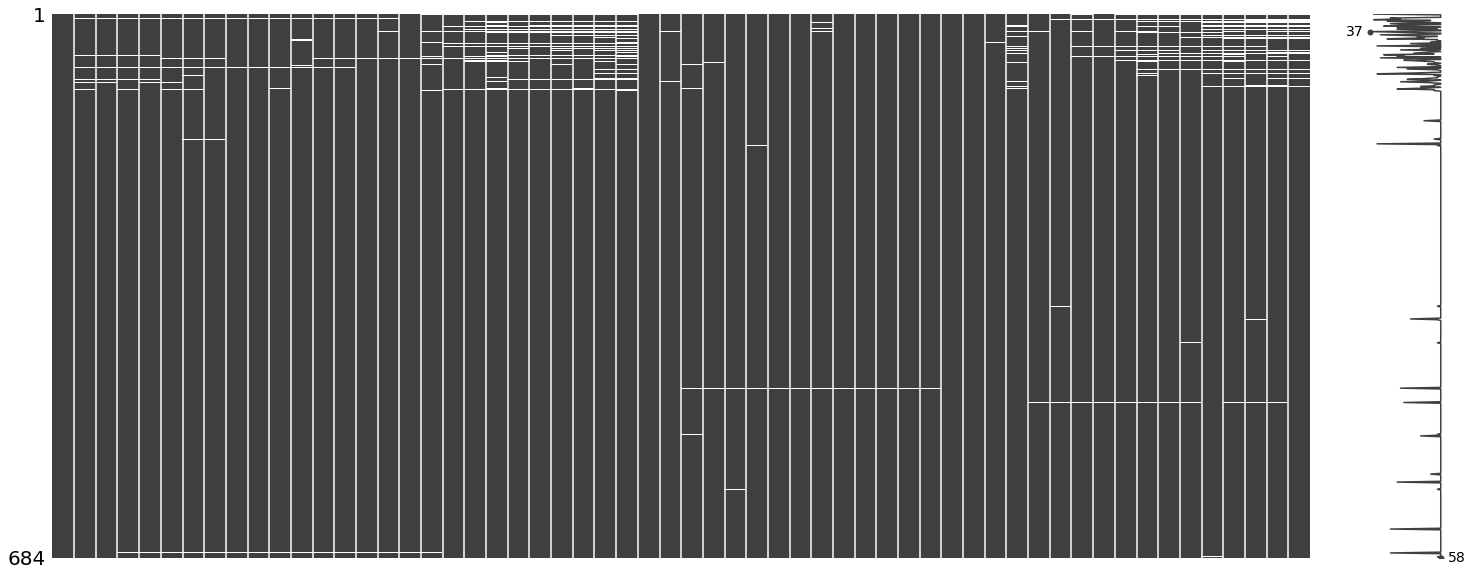

In [208]:
import missingno as msno

msno.matrix(gm_test_feat)

#### Interpolate missing values with Spline interpolation

In [232]:
# Transpose and set station id as columns 
gm_test_t=gm_test_feat.T
gm_test_t.columns = gm_test_t.iloc[0]
gm_test_t = gm_test_t[1:]
gm_test_t

station_id,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BLC,CDEC:BLK,CDEC:BLS,CDEC:BMW,CDEC:BNK,CDEC:BSK,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2020-01-07,12.72,12.2,6.6,5.76,3.24,12.5,12.72,9.0,8.88,12.4,...,6.9,1.6,2.9,3.7,18.0,6.8,13.8,4.4,37.9,17.7
2020-01-14,13.78,12.2,5.76,7.08,5.4,13.5,13.32,9.2,11.16,12.6,...,11.0,1.8,3.0,5.8,22.5,12.5,17.0,5.0,47.0,23.6
2020-01-21,17.12,13.3,5.16,9.72,7.44,14.6,15.72,10.2,15.24,13.6,...,11.7,1.9,3.0,NaN,24.0,13.1,20.3,5.8,51.8,27.9
2020-01-28,18.07,13.35,7.68,10.32,6.84,15.2,16.56,11.2,16.44,14.2,...,13.8,2.0,3.6,NaN,27.1,14.4,24.9,6.2,61.9,32.0
2020-02-04,18.17,12.85,4.68,10.2,6.36,15.3,16.56,11.2,17.04,14.4,...,14.8,3.3,4.3,NaN,29.1,16.3,26.7,6.3,69.0,33.7
2020-02-11,18.38,12.72,1.32,10.8,6.12,16.0,15.96,10.7,18.96,14.0,...,18.1,4.3,5.5,NaN,29.7,19.1,29.4,6.8,73.4,39.9
2020-02-18,17.71,12.72,0.84,10.08,5.04,16.1,16.8,10.3,19.2,14.4,...,19.6,4.9,6.7,NaN,31.2,19.8,29.8,7.2,77.3,44.2
2020-02-25,16.05,12.8,0.84,10.2,3.36,15.9,16.8,10.4,19.56,14.9,...,19.9,5.4,7.2,NaN,32.2,19.8,31.1,7.4,81.4,48.1
2020-03-03,14.62,13.16,0.24,10.56,1.44,15.7,16.32,10.0,18.48,13.7,...,20.0,5.5,8.5,NaN,33.1,19.7,32.6,7.8,83.6,52.6
2020-03-10,12.79,12.82,0.24,10.8,1.92,15.6,15.84,12.0,17.16,13.1,...,20.2,5.7,8.6,NaN,34.6,19.9,34.6,8.3,86.9,55.9


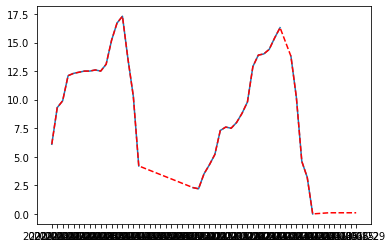

In [233]:
#Set date to datetime and as index
# gm_t.index = pd.to_datetime(gm_t.index)

#Test interpolation code on 1 station
plt.plot(gm_test_t ['CDEC:CDP'])
interpolated = gm_test_t['CDEC:CDP'].astype(float).interpolate(option='spline')

plt.plot(interpolated, color='r', linestyle='--')

In [234]:
#Get list of our columns
stations_list = list(gm_test_t.columns)


#Apply interpolation to every station
for station in stations_list:
    gm_test_t[station] = gm_test_t[station].astype(float).interpolate(option='spline', limit_direction = 'backward')

#Sniff test
gm_test_t

station_id,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BLC,CDEC:BLK,CDEC:BLS,CDEC:BMW,CDEC:BNK,CDEC:BSK,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2020-01-07,12.72,12.20,6.60,5.76,3.24,12.50,12.72,9.000,8.88,12.400000,...,6.9,1.6,2.9,3.7000,18.0,6.8,13.8,4.4,37.90,17.7
2020-01-14,13.78,12.20,5.76,7.08,5.40,13.50,13.32,9.200,11.16,12.600000,...,11.0,1.8,3.0,5.8000,22.5,12.5,17.0,5.0,47.00,23.6
2020-01-21,17.12,13.30,5.16,9.72,7.44,14.60,15.72,10.200,15.24,13.600000,...,11.7,1.9,3.0,5.4375,24.0,13.1,20.3,5.8,51.80,27.9
2020-01-28,18.07,13.35,7.68,10.32,6.84,15.20,16.56,11.200,16.44,14.200000,...,13.8,2.0,3.6,5.0750,27.1,14.4,24.9,6.2,61.90,32.0
2020-02-04,18.17,12.85,4.68,10.20,6.36,15.30,16.56,11.200,17.04,14.400000,...,14.8,3.3,4.3,4.7125,29.1,16.3,26.7,6.3,69.00,33.7
2020-02-11,18.38,12.72,1.32,10.80,6.12,16.00,15.96,10.700,18.96,14.000000,...,18.1,4.3,5.5,4.3500,29.7,19.1,29.4,6.8,73.40,39.9
2020-02-18,17.71,12.72,0.84,10.08,5.04,16.10,16.80,10.300,19.20,14.400000,...,19.6,4.9,6.7,3.9875,31.2,19.8,29.8,7.2,77.30,44.2
2020-02-25,16.05,12.80,0.84,10.20,3.36,15.90,16.80,10.400,19.56,14.900000,...,19.9,5.4,7.2,3.6250,32.2,19.8,31.1,7.4,81.40,48.1
2020-03-03,14.62,13.16,0.24,10.56,1.44,15.70,16.32,10.000,18.48,13.700000,...,20.0,5.5,8.5,3.2625,33.1,19.7,32.6,7.8,83.60,52.6
2020-03-10,12.79,12.82,0.24,10.80,1.92,15.60,15.84,12.000,17.16,13.100000,...,20.2,5.7,8.6,2.9000,34.6,19.9,34.6,8.3,86.90,55.9


In [235]:
#Look at percentage of null values 
(gm_test_t.isna().sum().sort_values(ascending=False)[:50])*100/57

station_id
CDEC:INN               12.280702
CDEC:EP5               10.526316
CDEC:HVN                8.771930
CDEC:BSK                8.771930
CDEC:CSL                8.771930
CDEC:SDW                8.771930
CDEC:CDP                8.771930
CDEC:DSS                8.771930
CDEC:BMW                8.771930
CDEC:VRG                8.771930
CDEC:BLK                8.771930
SNOTEL:1084_OR_SNTL     8.771930
CDEC:FDC                7.017544
CDEC:BLC                5.263158
CDEC:IDP                3.508772
CDEC:SQV                3.508772
CDEC:CWF                3.508772
SNOTEL:734_WA_SNTL      3.508772
CDEC:FLL                1.754386
SNOTEL:640_AZ_SNTL      0.000000
SNOTEL:643_UT_SNTL      0.000000
SNOTEL:637_ID_SNTL      0.000000
SNOTEL:646_MT_SNTL      0.000000
SNOTEL:644_WA_SNTL      0.000000
SNOTEL:645_ID_SNTL      0.000000
SNOTEL:629_CO_SNTL      0.000000
SNOTEL:647_OR_SNTL      0.000000
SNOTEL:648_WA_SNTL      0.000000
SNOTEL:649_MT_SNTL      0.000000
SNOTEL:650_ID_SNTL      0.000000

In [236]:
#Check for patterns in the missing values

dump_list = list((gm_test_t.isna().sum().sort_values(ascending=False)[:9]).index)

gm_test_t[dump_list]

station_id,CDEC:INN,CDEC:EP5,CDEC:HVN,CDEC:BSK,CDEC:CSL,CDEC:SDW,CDEC:CDP,CDEC:DSS,CDEC:BMW
2020-01-07,5.0,15.6,7.400000,12.400000,12.000000,6.700000,6.100000,11.70,9.000
2020-01-14,4.3,16.5,7.600000,12.600000,14.100000,6.700000,9.300000,16.20,9.200
2020-01-21,5.6,17.4,8.900000,13.600000,16.300000,7.500000,9.900000,18.50,10.200
2020-01-28,5.1,17.9,9.500000,14.200000,17.500000,7.900000,12.100000,22.80,11.200
2020-02-04,4.9,18.3,9.800000,14.400000,17.300000,7.800000,12.300000,23.30,11.200
2020-02-11,4.3,19.5,10.000000,14.000000,16.800000,8.100000,12.400000,23.60,10.700
2020-02-18,6.8,19.6,9.800000,14.400000,16.400000,8.300000,12.500000,25.20,10.300
2020-02-25,6.4,19.3,9.900000,14.900000,15.800000,8.500000,12.500000,25.60,10.400
2020-03-03,4.8,18.3,10.500000,13.700000,14.000000,8.700000,12.600000,25.20,10.000
2020-03-10,2.5,17.3,9.900000,13.100000,12.700000,9.900000,12.500000,25.10,12.000


So the remaining stations that have missing values are missing values in the tail end of 2021's melt season. We'll leave this be and impute these values with a more robut imputation method in our modeling workflow.

In [239]:
#Transpose back to our original dataframe shape.
gm_test_feat=gm_test_t.T
gm_test_feat.reset_index(inplace=True)
gm_test_feat

,station_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
1,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
2,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
3,CDEC:BFL,5.76,7.08,9.72,10.32,10.20,10.80,10.08,10.20,10.56,...,12.36,5.04,0.12,0.12,0.12,0.00,0.00,0.12,0.00,0.12
4,CDEC:BLC,3.24,5.40,7.44,6.84,6.36,6.12,5.04,3.36,1.44,...,0.45,0.42,0.44,0.54,0.36,0.40,0.34,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,SNOTEL:989_ID_SNTL,6.80,12.50,13.10,14.40,16.30,19.10,19.80,19.80,19.70,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
669,SNOTEL:990_WA_SNTL,13.80,17.00,20.30,24.90,26.70,29.40,29.80,31.10,32.60,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
670,SNOTEL:992_UT_SNTL,4.40,5.00,5.80,6.20,6.30,6.80,7.20,7.40,7.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
671,SNOTEL:998_WA_SNTL,37.90,47.00,51.80,61.90,69.00,73.40,77.30,81.40,83.60,...,96.00,95.10,95.50,94.20,94.20,84.65,75.10,70.40,58.70,35.10


Let's update our ground measures station list with the updated stations

In [27]:
stations_list = list(gm_train_feat.station_id.unique())
gm_md = gm_md[gm_md['station_id'].isin(stations_list)]
gm_md

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,POINT (-119.14173 37.72663)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
5,CDEC:BFL,Big Flat,1554.480000,41.077599,-122.942230,California,POINT (-122.94223 41.07760)
...,...,...,...,...,...,...,...
755,SNOTEL:989_ID_SNTL,Moscow Mountain,1432.560059,46.805000,-116.853500,Idaho,POINT (-116.85350 46.80500)
756,SNOTEL:990_WA_SNTL,Beaver Pass,1106.423950,48.879299,-121.255501,Washington,POINT (-121.25550 48.87930)
758,SNOTEL:992_UT_SNTL,Bear River RS,2675.229492,40.885201,-110.827698,Utah,POINT (-110.82770 40.88520)
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington,POINT (-121.43895 48.85933)


The dataset below is the ground truth data for our testing data. This will be reserved to test our model performance on unseen data.

### Testing labels

In [53]:
test_labels = pd.read_csv("../data/labels_2020_2021.csv")
test_labels = test_labels.melt(id_vars=["cell_id"]).dropna()
test_labels


,cell_id,variable,value
29,00c4db22-a423-41a4-ada6-a8b1b04153a4,2020-01-07,8.0
64,018cf1a1-f945-4097-9c47-0c4690538bb5,2020-01-07,11.4
68,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2020-01-07,18.5
93,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2020-01-07,3.9
95,02cf33c2-c8e2-48b9-bf72-92506e97e251,2020-01-07,13.0
...,...,...,...
516655,fd4492f2-8aa9-4279-bdc0-73991786943f,2021-06-29,0.0
516678,fde3221a-9ce3-45a9-857f-bd196b07aa05,2021-06-29,0.0
516680,fdeb8912-f9d1-445d-aadb-e943534f67fe,2021-06-29,0.0
516693,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2021-06-29,0.0


In [20]:
# Transpose and set station id as columns 
gm_t=gm_train_feat.T
gm_t.columns = gm_t.iloc[0]
gm_t = gm_t[1:]
gm_t

station_id,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BGP,CDEC:BIM,CDEC:BKL,CDEC:BLA,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2013-01-01,5.9,17.52,12.75,4.3,2.88,6.6,7.2,19.32,16.56,4.92,...,6.0,1.1,1.0,3.9,19.2,9.0,27.5,4.1,48.4,33.1
2013-01-08,5.9,17.54,13.32,4.42,3.0,7.92,7.28,19.32,17.04,5.64,...,6.6,1.2,1.6,4.3,20.0,10.2,29.1,4.1,55.5,37.5
2013-01-15,6.5,17.85,14.26,4.62,3.48,8.76,7.79,20.16,18.72,7.32,...,7.7,1.8,1.5,5.1,21.7,10.9,31.5,4.4,61.5,40.8
2013-01-22,6.5,17.39,14.02,4.53,3.84,9.0,7.8,20.28,19.2,7.56,...,8.0,1.9,2.0,5.1,21.9,11.1,31.9,4.5,62.2,42.5
2013-01-29,7.4,18.03,13.39,4.67,3.96,10.44,8.35,20.52,19.08,8.28,...,9.7,2.3,2.1,6.4,23.5,12.8,33.4,4.8,67.5,47.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03,0.7,0.0,5.69,NaN,2.88,3.0,NaN,NaN,6.72,0.0,...,1.5,1.4,2.5,1.4,5.9,0.3,1.0,2.0,8.0,1.6
2019-12-10,1.2,0.6,8.04,NaN,4.56,3.36,NaN,NaN,5.88,0.12,...,2.7,1.7,2.7,1.6,7.7,0.2,0.9,2.2,9.0,0.2
2019-12-17,3.4,0.2,10.74,NaN,4.68,4.56,NaN,NaN,6.12,0.72,...,4.4,1.7,2.7,2.6,9.0,1.6,2.3,3.5,13.2,3.5
2019-12-24,3.7,NaN,12.67,NaN,5.04,5.04,NaN,NaN,10.56,0.36,...,5.0,1.6,2.5,2.3,14.5,2.8,8.7,3.6,23.7,8.4


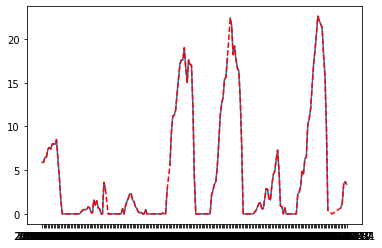

In [21]:
#Set date to datetime and as index
# gm_t.index = pd.to_datetime(gm_t.index)

#Test interpolation code on 1 station
plt.plot(gm_t ['CDEC:ADM'])
interpolated = gm_t['CDEC:ADM'].astype(float).interpolate(option='spline')

plt.plot(interpolated, color='r', linestyle='--')

In [22]:
#Get list of our columns
stations_list = list(gm_t.columns)


#Apply interpolation to every station
for station in stations_list:
    gm_t[station] = gm_t[station].astype(float).interpolate(option='spline')

#Sniff test
gm_t

station_id,CDEC:ADM,CDEC:AGP,CDEC:ALP,CDEC:BCB,CDEC:BCH,CDEC:BFL,CDEC:BGP,CDEC:BIM,CDEC:BKL,CDEC:BLA,...,SNOTEL:978_ID_SNTL,SNOTEL:981_MT_SNTL,SNOTEL:982_WY_SNTL,SNOTEL:984_WA_SNTL,SNOTEL:988_ID_SNTL,SNOTEL:989_ID_SNTL,SNOTEL:990_WA_SNTL,SNOTEL:992_UT_SNTL,SNOTEL:998_WA_SNTL,SNOTEL:999_WA_SNTL
2013-01-01,5.9,17.52,12.75,4.30,2.88,6.60,7.20,19.32,16.56,4.92,...,6.0,1.1,1.0,3.9,19.2,9.0,27.5,4.1,48.4,33.1
2013-01-08,5.9,17.54,13.32,4.42,3.00,7.92,7.28,19.32,17.04,5.64,...,6.6,1.2,1.6,4.3,20.0,10.2,29.1,4.1,55.5,37.5
2013-01-15,6.5,17.85,14.26,4.62,3.48,8.76,7.79,20.16,18.72,7.32,...,7.7,1.8,1.5,5.1,21.7,10.9,31.5,4.4,61.5,40.8
2013-01-22,6.5,17.39,14.02,4.53,3.84,9.00,7.80,20.28,19.20,7.56,...,8.0,1.9,2.0,5.1,21.9,11.1,31.9,4.5,62.2,42.5
2013-01-29,7.4,18.03,13.39,4.67,3.96,10.44,8.35,20.52,19.08,8.28,...,9.7,2.3,2.1,6.4,23.5,12.8,33.4,4.8,67.5,47.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03,0.7,0.00,5.69,81.22,2.88,3.00,7.33,21.24,6.72,0.00,...,1.5,1.4,2.5,1.4,5.9,0.3,1.0,2.0,8.0,1.6
2019-12-10,1.2,0.60,8.04,81.22,4.56,3.36,7.33,21.24,5.88,0.12,...,2.7,1.7,2.7,1.6,7.7,0.2,0.9,2.2,9.0,0.2
2019-12-17,3.4,0.20,10.74,81.22,4.68,4.56,7.33,21.24,6.12,0.72,...,4.4,1.7,2.7,2.6,9.0,1.6,2.3,3.5,13.2,3.5
2019-12-24,3.7,0.20,12.67,81.22,5.04,5.04,7.33,21.24,10.56,0.36,...,5.0,1.6,2.5,2.3,14.5,2.8,8.7,3.6,23.7,8.4


In [23]:
#Look at percentage of null values 
(gm_t.isna().sum().sort_values(ascending=False)[:50])*100/213

station_id
SNOTEL:1280_UT_SNTL    55.399061
SNOTEL:1278_UT_SNTL    55.399061
SNOTEL:1277_CA_SNTL    55.399061
SNOTEL:1252_CO_SNTL    55.399061
SNOTEL:1271_AZ_SNTL    40.845070
SNOTEL:1269_UT_SNTL    40.845070
CDEC:PSN               26.291080
SNOTEL:1263_WA_SNTL    26.291080
SNOTEL:1262_NV_SNTL    26.291080
SNOTEL:1261_UT_SNTL    26.291080
SNOTEL:1257_WA_SNTL    26.291080
SNOTEL:1251_CO_SNTL    26.291080
SNOTEL:1256_WA_SNTL    26.291080
SNOTEL:1148_UT_SNTL    26.291080
SNOTEL:1258_CA_SNTL    25.821596
SNOTEL:1259_WA_SNTL    25.352113
SNOTEL:1243_NV_SNTL    12.206573
SNOTEL:1244_NV_SNTL    12.206573
SNOTEL:1247_UT_SNTL    12.206573
SNOTEL:1248_UT_SNTL    12.206573
SNOTEL:1249_UT_SNTL    12.206573
SNOTEL:1254_NM_SNTL    12.206573
SNOTEL:1242_NV_SNTL    12.206573
SNOTEL:1236_UT_SNTL    12.206573
SNOTEL:1187_CO_SNTL    12.206573
CDEC:CDP                0.938967
CDEC:BLC                0.469484
SNOTEL:616_WY_SNTL      0.000000
SNOTEL:615_NV_SNTL      0.000000
SNOTEL:617_AZ_SNTL      0.000000

In [24]:
#Check for patterns in the missing values

dump_list = list((gm_t.isna().sum().sort_values(ascending=False)[:10]).index)

gm_t[dump_list].head(100)

station_id,SNOTEL:1280_UT_SNTL,SNOTEL:1278_UT_SNTL,SNOTEL:1277_CA_SNTL,SNOTEL:1252_CO_SNTL,SNOTEL:1271_AZ_SNTL,SNOTEL:1269_UT_SNTL,CDEC:PSN,SNOTEL:1263_WA_SNTL,SNOTEL:1262_NV_SNTL,SNOTEL:1261_UT_SNTL
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2016-01-26,NaN,NaN,NaN,NaN,10.8,5.7,12.5,21.7,4.7,5.3
2016-02-02,NaN,NaN,NaN,NaN,12.3,6.6,14.1,21.5,5.9,6.2
2016-02-09,NaN,NaN,NaN,NaN,12.2,6.7,14.0,23.8,5.9,6.5
2016-02-16,NaN,NaN,NaN,NaN,12.0,6.7,13.4,23.8,3.8,6.5


So all the remaining stations that have more than 50% of missing values seem to have missing values between 2013 until 2016. While stations with 40% of missing values after interpolation are missing values from 2013 until the end of 2015. 

It's impossible to interpolate 4 straight years of missing data. So, let's rid of the stations that have more than 50% of missing values from those 4 missing years.

In [25]:
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


In [26]:
#Transpose back to our original dataframe shape.
gm_train_feat=gm_t.T
gm_train_feat.reset_index(inplace=True)

#Drop more stations
dump_list = list((gm_t.isna().sum().sort_values(ascending=False)[:4]).index)

#Add on stations that doesn't have data the whole of 2019.
dump_list.extend(['CDEC:BCB','CDEC:BGP','CDEC:BIM'])

#Filter and get the list
mask = ~(gm_train_feat['station_id'].isin(dump_list))

#Drop the stations in the original dataframe
gm_train_feat = gm_train_feat[mask]
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,0.116667,0.233333,0.350000,0.466667,0.583333,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,0.251613,0.201290,0.150968,0.100645,0.050323,0.00,0.60,0.20,0.20,0.20
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.520000,20.810000,8.710000,0.300000,0.000000,5.69,8.04,10.74,12.67,12.57
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.840000,0.600000,0.360000,0.360000,0.240000,2.88,4.56,4.68,5.04,6.00
5,CDEC:BFL,6.60,7.92,8.76,9.00,10.44,10.80,11.16,11.28,12.00,...,0.270000,0.150000,0.270000,0.390000,0.270000,3.00,3.36,4.56,5.04,5.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.30,0.20,1.60,2.80,3.00
688,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.000000,0.100000,0.000000,0.000000,0.000000,1.00,0.90,2.30,8.70,8.60
689,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.00,2.20,3.50,3.60,3.80
690,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.600000,36.100000,31.300000,8.500000,0.000000,8.00,9.00,13.20,23.70,25.00


Let's update our ground measures station list with the updated stations

In [27]:
stations_list = list(gm_train_feat.station_id.unique())
gm_md = gm_md[gm_md['station_id'].isin(stations_list)]
gm_md

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,POINT (-119.14173 37.72663)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
5,CDEC:BFL,Big Flat,1554.480000,41.077599,-122.942230,California,POINT (-122.94223 41.07760)
...,...,...,...,...,...,...,...
755,SNOTEL:989_ID_SNTL,Moscow Mountain,1432.560059,46.805000,-116.853500,Idaho,POINT (-116.85350 46.80500)
756,SNOTEL:990_WA_SNTL,Beaver Pass,1106.423950,48.879299,-121.255501,Washington,POINT (-121.25550 48.87930)
758,SNOTEL:992_UT_SNTL,Bear River RS,2675.229492,40.885201,-110.827698,Utah,POINT (-110.82770 40.88520)
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington,POINT (-121.43895 48.85933)


## Step-up/Level ups

### MODIS data

#### Helper Functions

In [ ]:
from gcloud import storage


def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)

    print('Blob {} downloaded to {}.'.format(
        source_blob_name,
        destination_file_name))
download_blob("datset","actions", "dataset")

In [ ]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'snow-water-equivalent'
# !gcloud config set project {project_id}
project_name = 'Snow-Water-Equivalent'
bucket_name = 'modis-swe'

fs = gcsfs.GCSFileSystem(projectstring=project_id)
fs.ls(bucket_name)

In [ ]:
import requests

authCode = YOUR_AUTH_CODE
auth = "Bearer " + authCode
myHeaders = {"Authorization": auth}
r = requests.get('https://www.googleapis.com/storage/v1/b/BUCKET_NAME/o/OBJECT_NAME', headers=myHeaders)

print r.text
print r.status_code

These helper functions are from a notebook example provided by [DrivenData](https://www.drivendata.org/competitions/86/competition-reclamation-snow-water-dev/page/417/) [here](https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/modis.ipynb).

In [101]:
import tempfile
import wget
import numpy as np
import matplotlib.pyplot as plt
import os

from azure.storage.blob import ContainerClient

ModuleNotFoundError: No module named 'azure'

In [98]:
def lat_lon_to_modis_tile(lat,lon):
    """
    Get the modis tile indices (h,v) for a given lat/lon
    
    https://www.earthdatascience.org/tutorials/convert-modis-tile-to-lat-lon/
    """
    
    found_matching_tile = False
    i = 0
    while(not found_matching_tile):
        found_matching_tile = lat >= modis_tile_extents[i, 4] \
        and lat <= modis_tile_extents[i, 5] \
        and lon >= modis_tile_extents[i, 2] and lon <= modis_tile_extents[i, 3]
        i += 1
        
    v = int(modis_tile_extents[i-1, 0])
    h = int(modis_tile_extents[i-1, 1])
    
    return h,v


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files   